# TODO: 
1. Drone slows down when nearing rings, can make this speed up by a little

Currently sitting at ~41-42 second runs, not yet tested for consistency

In [740]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone
import sympy as sym
import numpy as np
from control import lqr

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

# Linearize the system
m = sym.Matrix([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
n = sym.Matrix([tau_x, tau_y, tau_z, f_z])
o = sym.Matrix([p_x, p_y, p_z, psi, theta, phi])
sub = {
    p_x: 0.0,
    p_y: 0.0,
    p_z: 0.0,
    psi: 0.0,
    theta: 0.0,
    phi: 0.0,
    v_x: 0.0,
    v_y: 0.0,
    v_z: 0.0,
    w_x: 0.0,
    w_y: 0.0,
    w_z: 0.0,
    tau_x: 0.0,
    tau_y: 0.0,
    tau_z: 0.0,
    f_z: 981./100./2.,
}
m_e = np.array(m.subs(sub)).astype(np.float64)
n_e = np.array(n.subs(sub)).astype(np.float64)
o_e = np.array(o.subs(sub)).astype(np.float64)

A = f.jacobian(m).subs(sub)
B = f.jacobian(n).subs(sub)
C = g.jacobian(m).subs(sub)

A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
C = np.array(C).astype(np.float64)

Q_enter_zig = np.diag([0.15, 0.15, 0.15, 1, 1, 1,
                        1, 1, 1, 1, 1, 1])
Q_startend = np.diag([0.15, 0.15, 7.5, 1, 1, 1,
                        1, 1, 1, 1, 1, 1])
Q_zigzag = np.diag([0.09, 0.09, 10, 1, 1, 1,
                    1, 1, 1, 1, 1, 1]) # good for zigzag
Q_fasty = np.diag([0.1, 0.15, 10, 1, 1, 1,
                    1, 1, 1, 1, 1, 1]) # good for fast y
Q_ringx = np.diag([0.13, 0.15, 9.5, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])
Q_ringy = np.diag([0.08, 0.1, 7, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])
Q_back1 = np.diag([0.25, 0.25, 0.25, 1, 1, 1,
                    1, 1, 1, 1, 1, 1]) # testing
Q_13 = np.diag([0.1, 0.1, 13, 1, 1, 1,
                    1, 1, 1, 1, 1, 1]) # testing

# Rc = np.diag([.95, .95, .95, .95]) * 1e2
Rc = np.diag([1, 1, 1, 1]) * 1e2 * 0.9

K_enter_zig, _, _ = lqr(A, B, Q_enter_zig, Rc)
K_startend, _, _ = lqr(A, B, Q_startend, Rc)
K_zigzag, _, _ = lqr(A, B, Q_zigzag, Rc)
K_fasty, _, _ = lqr(A, B, Q_fasty, Rc)
K_ringx, _, _ = lqr(A, B, Q_ringx, Rc)
K_ringy, _, _ = lqr(A, B, Q_ringy, Rc)
K_back1, _, _ = lqr(A, B, Q_back1, Rc)
K_13, _, _ = lqr(A, B, Q_13, Rc)

Qo = np.diag([1, 1, 1, 1, 1, 1]) * 1e2
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1e2
L, _, _ = lqr(A.T, C.T, np.linalg.inv(Ro), np.linalg.inv(Qo))
L = L.T

class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        self.variables_to_log = []
        self.dt = 0.04
        self.slope = None
        self.zigzag = None
        self.ring_radius = 1.0

    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        """
        Replace the following line (a placeholder) with your
        own code.
        """
        self.p_x = p_x
        self.p_y = p_y
        self.p_z = p_z
        self.yaw = yaw
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.passed_rings = []
        self.next_ring = []
        self.passed_checkpoints = []
        self.next_checkpoints = []
    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on left rotor (meters),
                measured y position of marker on left rotor (meters),
                measured z position of marker on left rotor (meters),
                measured x position of marker on right rotor (meters),
                measured y position of marker on right rotor (meters),
                measured z position of marker on right rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all other active drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """

        def reached_destination(xhat, goal):
            return np.linalg.norm(xhat - goal) < 0.75
        
        def get_next_checkpoint(ring_pos, current_checkpoint_pos, ring_radius, forward):
            # Calculate the slope of the line connecting the current ring and checkpoint
            slope = 0.9 * (current_checkpoint_pos[1] - ring_pos[1]) / (current_checkpoint_pos[0] - ring_pos[0])
            # Calculate the x and y coordinates of the next checkpoint
            if (forward):
                x_next = ring_pos[0] + self.ring_radius
                y_next = ring_pos[1] + slope * ring_radius
            else:
                x_next = ring_pos[0] - self.ring_radius
                y_next = ring_pos[1] - slope * ring_radius
            return np.array([x_next, y_next, ring_pos[2]])
        
        def get_drone_dir(initial_pos, goal):
            dir = np.array([goal[0] - initial_pos[0], goal[1] - initial_pos[1], goal[2] - initial_pos[2]])
            return dir / np.linalg.norm(dir)
        
        def turning(direction):
            threshold = 0.1
            if direction == "x":
                return abs(self.xhat[6]) < threshold
            elif direction == "y":
                return abs(self.xhat[7]) < threshold
            elif direction == "z":
                return abs(self.xhat[8]) < threshold
            else:
                raise ValueError("Invalid direction. Choose 'x', 'y', or 'z'.")

        # Default x_des, moves towards the ring
        x_des = np.array([*pos_ring, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        if (len(self.next_ring) == 0 or not np.allclose(pos_ring, self.next_ring[-1], atol=1e-3)): # runs everytime pos_ring changes
            self.next_ring.append(pos_ring.copy())
            if (len(self.next_ring) > 1):
                self.passed_rings.append(self.next_ring[-2].copy())
        
        # Track the rings, save each ring location to self.passed_rings
        dist_to_ring = np.linalg.norm(self.xhat[:3] - pos_ring)
        
        # If before ring 8, drone is moving forward, if after ring 8, drone is moving backward
        forward = True
        if (len(self.passed_rings) >= 8):
            forward = False

        # Ensure drone rises above initial blue ring quickly
        if (self.xhat[2] < 2.0 and len(self.passed_checkpoints) == 0):
            checkpoint = np.array([self.p_x, self.p_y, 1.075])
            x_des[:3] = checkpoint + np.array([0, 0, 15.0])
            if reached_destination(self.xhat[:3], checkpoint):
                self.passed_checkpoints.append(self.xhat[:3].copy())
                self.next_checkpoints.append(self.xhat[:3].copy())
                print("Checkpoint 0 reached")
        
        # Ring 1
        if (len(self.passed_rings) == 0 and len(self.passed_checkpoints) == 1):
            x_des[:3] = self.next_ring[-1] + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.5 # Overshoot here
            if ((self.xhat[1] - self.next_ring[-1][1])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.1)**2):
                x_des[:3] = self.next_ring[-1] + np.array([2.0, 0, 0])

        if (len(self.passed_rings) == 1 and turning("y") and len(self.passed_checkpoints) == 1):
            print("Turning!!")
            print("Checkpoint 1 reached")
            self.passed_checkpoints.append(self.xhat[:3].copy())
            self.next_checkpoints.append(self.xhat[:3].copy())

        if (len(self.passed_rings) == 1 and len(self.passed_checkpoints) == 2):
            del_z = self.next_ring[-1][2] - self.passed_checkpoints[-1][2]
            x_des[:3] = pos_ring + np.array([0, 0, 0.0]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 2.5 # Overshoot here, max 2.0
            if (del_z < -0.5):
                x_des[2] += 1.0
            elif (del_z > 1.0):
                x_des[2] -= 0.5
            if ((self.xhat[0] - self.next_ring[-1][0])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2) and abs(self.xhat[1] - self.next_ring[-1][1]) > 1.25:
                x_des[:3] += dir_ring * 2.0

        # To get to first checkpoint after first zigzag ring, entering zigzag rings
        if len(self.passed_rings) == 2 and len(self.passed_checkpoints) == 2: 
            self.slope = 0.5 * (self.passed_rings[-1][1] - self.passed_rings[-2][1]) / (self.passed_rings[-1][0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius, 0])
            checkpoint = self.passed_rings[-1][:3] + self.zigzag
            x_des[:3] = checkpoint + np.array([0, 0, 0.75]) + get_drone_dir(self.passed_rings[-1], checkpoint) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], checkpoint):
                print("Checkpoint 2 reached")
                self.passed_checkpoints.append(checkpoint.copy())
                self.next_checkpoints.append(checkpoint.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint, self.ring_radius, forward)
                self.next_checkpoints.append(next_checkpoint.copy())

        # Approaching ring 3
        if (len(self.passed_checkpoints) == 3):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 3 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))

        # Approaching ring 4
        if (len(self.passed_checkpoints) == 4):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 4 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
        
        # Approaching ring 5
        if (len(self.passed_checkpoints) == 5):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 5 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
        
        # Approaching ring 6
        if (len(self.passed_rings) == 5 and len(self.passed_checkpoints) == 6):
            x_des[:3] = pos_ring + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 2.5 # Overshoot here

        # Approaching ring 7
        if (len(self.passed_rings) == 6 and len(self.passed_checkpoints) == 6 and all(self.passed_rings[-1] != pos_ring)):
            x_des[:3] = pos_ring + get_drone_dir(self.passed_rings[-1], pos_ring) * 3.0 # Overshoot here
            if ((self.xhat[1] - pos_ring[1])**2 + (self.xhat[2] - pos_ring[2])**2 < (self.ring_radius - 0.)**2):
                x_des[:3] = pos_ring + dir_ring * 2.0 # Overshoot here

        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 6):
            checkpoint = np.array([self.passed_rings[-1][0] + 0.6, self.passed_rings[-1][1], self.passed_rings[-1][2]])
            x_des[:3] = checkpoint + np.array([4.5, 0, 0]) # Overshoot here
            if (reached_destination(self.xhat[:3], checkpoint)):
                print("Checkpoint 6 reached")
                self.passed_checkpoints.append(checkpoint.copy())
                
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 7):
            checkpoint = np.array([pos_ring[0] + 0.50, pos_ring[1], pos_ring[2]]) ## For some reason, only pos_ring[0] + 1.0 and above works
            x_des[:3] = checkpoint + np.array([0, 1.5, 0]) ## Don't go above 2.0 # Overshoot here
            if ((self.xhat[1] - self.next_ring[-1][1])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2):
                print("Checkpoint 7 reached")
                self.passed_checkpoints.append(checkpoint.copy())
                x_des[:3] = pos_ring + dir_ring * 4.0 # Overshoot here
        
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 8):
            x_des[:3] = pos_ring + dir_ring * 4.0 # Overshoot here

        if (len(self.passed_rings) == 8 and len(self.passed_checkpoints) == 8):
            x_des[:3] = self.next_ring[-1] + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.5 # Overshoot here

        if (len(self.passed_rings) == 8 and turning("y") and len(self.passed_checkpoints) == 8):
            print("Turning!!")
            print("Checkpoint 8 reached")
            self.passed_checkpoints.append(self.xhat[:3].copy())
            self.next_checkpoints.append(self.xhat[:3].copy())

        if (len(self.passed_rings) == 8 and len(self.passed_checkpoints) == 9):
            del_z = self.next_ring[-1][2] - self.passed_checkpoints[-1][2]
            x_des[:3] = self.next_ring[-1] + np.array([0, 0, 0.0]) + get_drone_dir(self.passed_checkpoints[-1], self.next_ring[-1]) * 2.0 # Overshoot here
            if (del_z < 0.0):
                x_des[2] += 0.75
            elif (del_z > 1.0):
                x_des[2] -= 0.25
            if ((self.xhat[0] - self.next_ring[-1][0])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2) and abs(self.xhat[1] - self.next_ring[-1][1]) > 1.25:
                x_des[:3] += dir_ring * 2.0 # Overshoot here

        if len(self.passed_rings) == 9 and len(self.passed_checkpoints) == 9:
            self.slope = 0.60 * (self.passed_rings[-1][1] - self.passed_rings[-2][1]) / (self.passed_rings[-1][0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius, 0])
            checkpoint = self.passed_rings[-1] - self.zigzag
            x_des[:3] = checkpoint + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_rings[-1], checkpoint) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], checkpoint):
                print("Checkpoint 9 reached")
                self.passed_checkpoints.append(checkpoint.copy())
                self.next_checkpoints.append(checkpoint.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint, self.ring_radius, forward)
                self.next_checkpoints.append(next_checkpoint.copy())

        if (len(self.passed_checkpoints) == 10):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 10 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))

        if (len(self.passed_checkpoints) == 11):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 11 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
        
        if (len(self.passed_checkpoints) == 12):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                print("Checkpoint 12 reached")
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
        
        if (len(self.passed_rings) == 12 and len(self.passed_checkpoints) == 13):
            x_des[:3] = pos_ring + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.0 # Overshoot here

        if (len(self.passed_rings) == 13 and len(self.passed_checkpoints) == 13):
            self.passed_checkpoints.append(self.xhat[:3].copy())

        if (len(self.passed_rings) == 13 and all(self.passed_rings[-1] != pos_ring) and len(self.passed_checkpoints) == 14):
            x_des[:3] = self.next_ring[-1] + np.array([0, -0.5, 0]) + get_drone_dir(self.passed_checkpoints[-1], self.next_ring[-1]) * 2.5 # Overshoot here
            # if (reached_destination(self.xhat[:3], pos_ring)):
            if ((self.next_ring[-1][0] - self.xhat[0])**2 + (self.next_ring[-1][1] - self.xhat[1])**2 < (self.ring_radius - 0.4)**2):
                x_des[:3] = self.next_ring[-1] + dir_ring * 5.0
        
        if (is_last_ring):
            if (len(self.passed_checkpoints) == 14):
                R = 2.5
                checkpoint = np.array([0, 0, 1.75])
                x_des[:3] = checkpoint + get_drone_dir(self.passed_rings[-1], checkpoint) * 5.0 # Overshoot here
                if (self.xhat[0] < R*np.sqrt(2)/2 and self.xhat[1] > -R*np.sqrt(2)/2):
                    print("Checkpoint 13 reached")
                    self.passed_checkpoints.append(checkpoint.copy())
            else:
                x_des[:3] = np.array([0, 0, -50])
        if dist_to_ring < 1.0:
            # if len(self.passed_rings) == 0 or not np.allclose(pos_ring, self.passed_rings[-1], atol=1e-3):
            #     self.passed_rings.append(pos_ring.copy()) # doesn't count the beginning blue ring
            x_des[:3] += dir_ring * 3.0

        if (dist_to_ring < 1.0 and abs(dir_ring[0]) == 1):
            u = -K_ringx @ (self.xhat - x_des)
        elif (dist_to_ring < 1.0 and abs(dir_ring[1]) == 1):
            u = -K_ringy @ (self.xhat - x_des)
        elif (len(self.passed_rings) < 1): # approaching first ring or approaching last ring
            u = -K_startend @ (self.xhat - x_des)
        elif (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 7):
            u = -K_fasty @ (self.xhat - x_des)
        # elif (len(self.passed_rings) == 8):
        #     u = -K_back1 @ (self.xhat - x_des)
        elif (len(self.passed_rings) == 13):
            u = -K_13 @ (self.xhat - x_des)
        else:
            u = -K_zigzag @ (self.xhat - x_des)
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3] + n_e[3][0]

        y = np.array(pos_markers)

        x_hatdot = A @ self.xhat + B @ u - L @ (C @ self.xhat - y)
        self.xhat += + x_hatdot.flatten() * self.dt

        return tau_x, tau_y, tau_z, f_z

In [741]:
seed = secrets.randbits(32)
print(seed)
updown_seed = 2018987314
updown_seed2 = 247366554
bad = 2013604784
bad_new = 2645767789
bad2 = 3636293057 
hard_course = 1073562002
verybad = 535045273
meh = 939730283
tricky = 4071836738
simulator = ae353_drone.Simulator(seed=seed)

simulator.add_view(
    'top_view',  # name of view (must be unique)
    'top',       # type of view (start, top, right, left, or back)
)
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=True,  # <-- allow long runtimes in controller code
    error_on_inactive=True, # <-- allow inactivity
)
simulator.clear_drones()
# Add a drone to the simulator
simulator.add_drone(Controller, 'sub50', 'yawn.png')
simulator.add_drone_view(
    'drone_view',    # name of view (must be unique)
    'sub50',         # name of drone
    yaw=0.,             # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    pitch=0.,          # pitch angle in degrees,
    distance=4.,        # how far away the camera is from the center of the drone
)
simulator.reset()
simulator.run(
    max_time=None,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
    videos=[
        {
            'view_name': 'top_view',    # name of view from which to record a video
            'file_name': 'top_view.mp4',  # name of file to which video will be saved
        },
        {
            'view_name': 'drone_view',       # name of view from which to record a video
            'file_name': 'drone_view.mp4',       # name of file to which video will be saved
        }
    ],
    
)

(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('sub50')

if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

1271753641
argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7025/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7026/static/
Creating a video from view top_view with name top_view.mp4 and fps 25
Creating a video from view drone_view with name drone_view.mp4 and fps 25
Checkpoint 0 reached
 25 / None
 50 / None
 75 / None
Turning!!
Checkpoint 1 reached
 100 / None
 125 / None
 150 / None
 175 / None
Checkpoint 2 reached
 200 / None
 225 / None
Checkpoint 3 reached
 250 / None
Checkpoint 4 reached
 275 / None
 300 / None
Checkpoint 5 reached
 325 / None
 350 / None
 375 / None
 400 / None
 425 / None
Checkpoint 6 reached
 450 / None
 475 / None
 500 / None
 525 / None
 550 / None
Checkpoint 7 reached
Turning!!
Checkpoint 8 reached
 575 / None
 600 / None
 625 / None
 650 / None
 675 / None
Checkpoint 9 reached
 700 / None
 725 / None
Checkpoint 10 reached
 750 / None
 775 / None
Checkpoint 11 reached
 800 / None
Che

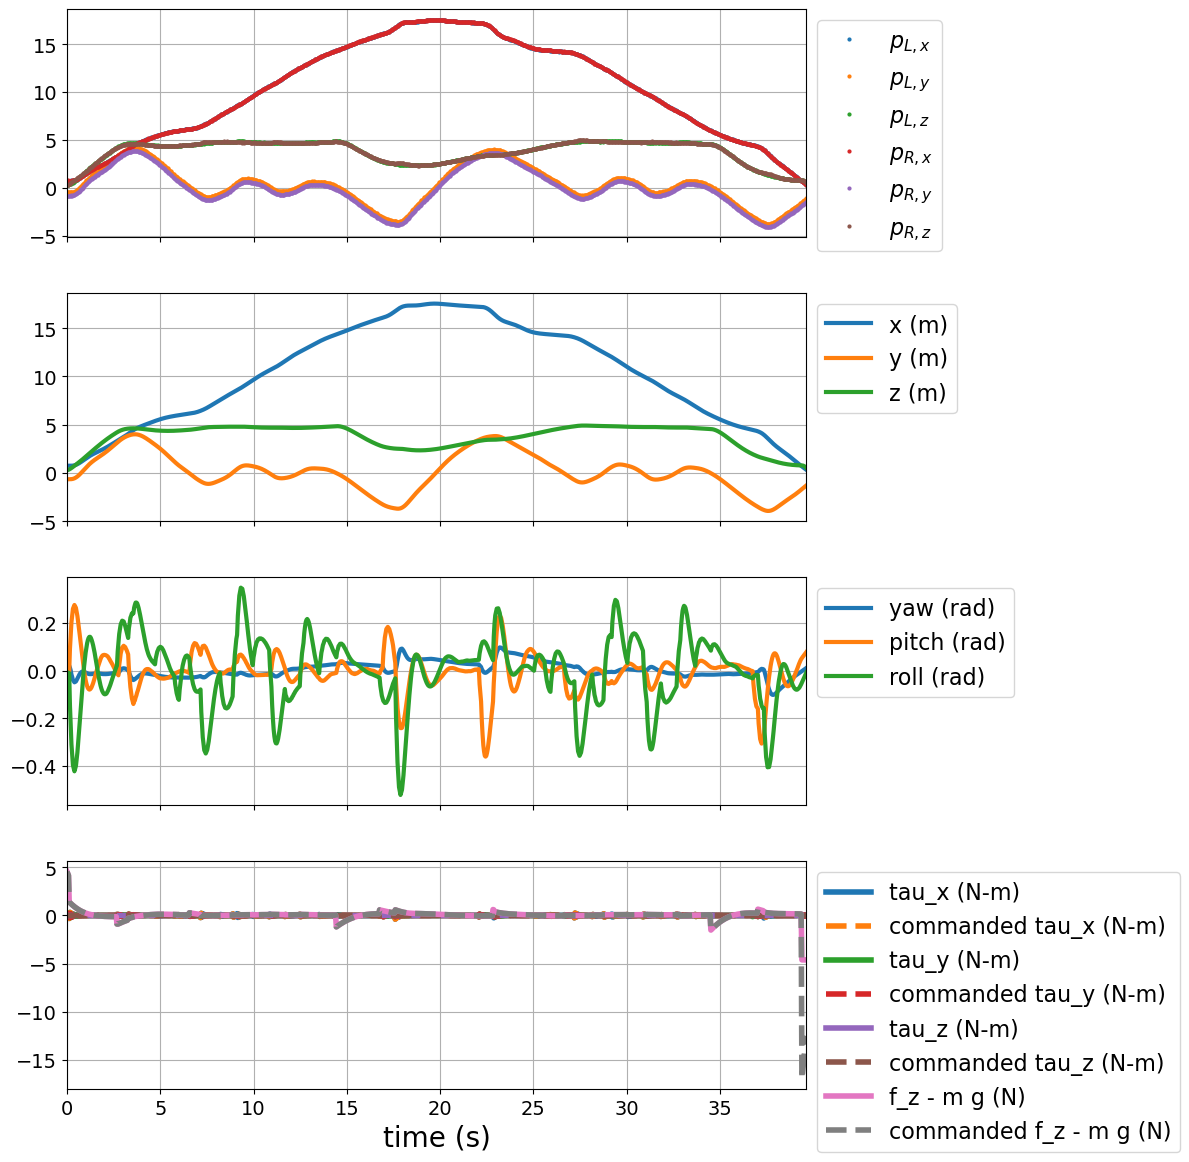

In [742]:
data = simulator.get_data('sub50')
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

fig.savefig('my_figure.png', facecolor='white', transparent=False)

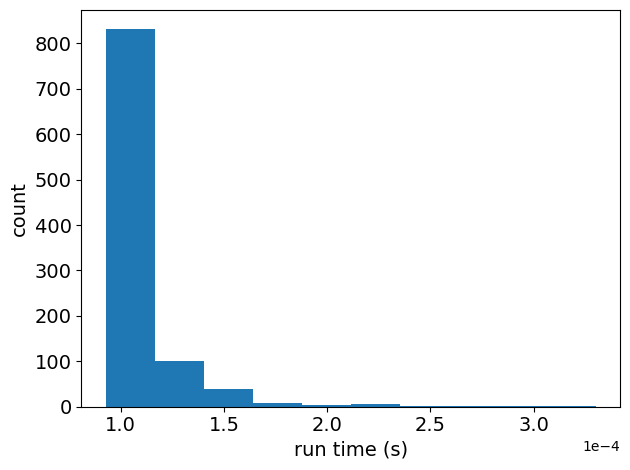

In [743]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()